In [9]:

import requests
from pydantic import BaseModel, constr
from typing import Optional, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.cluster import DBSCAN
import utm


%config InlineBackend. figure_format = 'retina'
sns.set()

BASE_URL = 'https://sherlock.aerobotics.com/developers'
token_path = 'api_token.txt'
with open(token_path, 'r', encoding='utf-8') as file:
    API_TOKEN = file.read()
orchid_id = 216269

In [2]:
class TreeSurvey(BaseModel):
    id: int
    survey_id: int
    latitude: float
    longitude: float
    radius: float
    ndre: float
    ndvi: float
    height: float
    area: float

class TreeSurveyResponse(BaseModel):
    count: int
    next: Optional[str]
    previous: Optional[str]
    results: List[TreeSurvey]

def get_treesurvey(orchard_id: str, api_token: str) -> TreeSurveyResponse:
    url = f"{BASE_URL}/treesurveys/?survey__orchard_id={orchard_id}"
    headers = {
        "accept": "application/json",
        "Authorization": api_token,
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        try:
            return TreeSurveyResponse.model_validate(response.json())
        except Exception as e:
            raise ValueError(f"Failed to parse response data: {e}")
    else:
        response.raise_for_status()


def treesurvey_to_dataframe(treesurvey_response: TreeSurveyResponse) -> pd.DataFrame:
    data = [treesurvey.model_dump() for treesurvey in treesurvey_response.results]
    df = pd.DataFrame(data)
    return df

In [3]:
try:
    orchard_id = "216269"
    result = get_treesurvey(orchard_id, API_TOKEN)
    print(result)
except Exception as e:
    print(f"Error: {e}")

count=508 next=None previous=None results=[TreeSurvey(id=54733434, survey_id=25319, latitude=-32.3279643, longitude=18.826872, radius=2.0, ndre=0.557, ndvi=0.872, height=3.25, area=22.667), TreeSurvey(id=54733276, survey_id=25319, latitude=-32.3281893, longitude=18.8263421, radius=2.0, ndre=0.559, ndvi=0.881, height=2.422, area=22.662), TreeSurvey(id=54733233, survey_id=25319, latitude=-32.3283205, longitude=18.8256169, radius=2.0, ndre=0.57, ndvi=0.888, height=2.949, area=25.908), TreeSurvey(id=54733009, survey_id=25319, latitude=-32.3287595, longitude=18.8262246, radius=2.0, ndre=0.499, ndvi=0.84, height=2.382, area=16.451), TreeSurvey(id=54733324, survey_id=25319, latitude=-32.3280753, longitude=18.8255473, radius=2.0, ndre=0.555, ndvi=0.869, height=3.178, area=25.914), TreeSurvey(id=54733279, survey_id=25319, latitude=-32.3280162, longitude=18.8263217, radius=2.0, ndre=0.572, ndvi=0.884, height=2.242, area=22.037), TreeSurvey(id=54733259, survey_id=25319, latitude=-32.3279874, long

In [4]:
import numpy as np
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

def convert_to_geodataframe(result):
    """Converts survey results to a GeoDataFrame with appropriate coordinate system."""
    df = treesurvey_to_dataframe(result)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))
    gdf.to_crs(gdf.estimate_utm_crs(), inplace=True)
    return gdf

def calculate_nearest_neighbors(gdf):
    """Calculates and returns the nearest neighbors of points in the GeoDataFrame."""
    points = np.column_stack((gdf.geometry.y, gdf.geometry.x))
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(points)
    return distances, indices, points

def align_grid(gdf, indices):
    """Rotates and normalizes grid points."""
    points = np.column_stack((gdf.geometry.y, gdf.geometry.x))
    delta = np.subtract(points[indices[:,0]], points[indices[:,1]])
    angles = np.arctan2(delta[:,0], delta[:,1])
    angles %= (np.pi/2)
    cy, cx = np.mean(points, axis=0)
    a = np.median(angles)
    R = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])
    centred_points = points - np.array([cy,cx])
    normalised_points = (R @ centred_points.T).T
    normalised_points -= np.min(normalised_points, axis=0)
    gdf['grid_x'] = normalised_points[:,1]
    gdf['grid_y'] = normalised_points[:,0]
    return gdf

def perform_clustering(gdf, distances):
    """Performs DBSCAN clustering and assigns row and column labels."""
    # Cluster vertically and horizontally, eps needs be small enough to prevent any overlapping between rows
    # We could adjust eps based on the allowable deviation between points in the rows/cols if it we want to 
    # support large orchards where the rows/cols curve
    eps = np.min(distances[:,1])/2
    dbscan = DBSCAN(eps=eps, min_samples=2, metric='manhattan')
    gdf['row_cluster'] = dbscan.fit(gdf['grid_y'].values.reshape((-1,1))).labels_
    gdf['col_cluster'] = dbscan.fit(gdf['grid_x'].values.reshape((-1,1))).labels_

    # Assign rows based on clusters, sorted in ascending order based on their median y value
    sorted_row_clusters = gdf.groupby('row_cluster')['grid_y'].median().sort_values().index.values
    gdf['row'] = gdf['row_cluster'].map({cluster: row for row, cluster in enumerate(sorted_row_clusters)})

    # Assign columns based on clusters, sorted in ascending order based on their median x value
    sorted_col_clusters = gdf.groupby('col_cluster')['grid_x'].median().sort_values().index.values
    gdf['col'] = gdf['col_cluster'].map({cluster: col for col, cluster in enumerate(sorted_col_clusters)})

    gdf.sort_values(by=['row', 'col'], inplace=True)
    return gdf

def detect_missing_points(gdf):
    """Detects and returns the missing points in the grid."""
    grid_points = {tuple(i):tuple(pt) for i, pt in zip(gdf[['row', 'col']].values, gdf[['grid_y','grid_x']].values)}
    missing = []
    for r in gdf[gdf['row']!=-1]['row'].unique():
        for c in gdf[gdf['col']!=-1]['col'].unique():
            if (r,c) not in grid_points:
                neighbours = [grid_points[pos] for pos in ((r-1,c), (r+1,c), (r,c-1), (r,c+1)) if pos in grid_points]
                if len(neighbours) > 2 :
                    missing.append(np.median(neighbours, axis=0))
    return np.array(missing)





# Main script
gdf = convert_to_geodataframe(result)
# gdf is a dataframe that looks like:
# 
#            id  survey_id   latitude  longitude  radius   ndre   ndvi  height  \
# 0    54733434      25319 -32.327964  18.826872     2.0  0.557  0.872   3.250   
# 1    54733276      25319 -32.328189  18.826342     2.0  0.559  0.881   2.422   
# 2    54733233      25319 -32.328320  18.825617     2.0  0.570  0.888   2.949   
# 3    54733009      25319 -32.328759  18.826225     2.0  0.499  0.840   2.382   
# 4    54733324      25319 -32.328075  18.825547     2.0  0.555  0.869   3.178


distances, indices, points = calculate_nearest_neighbors(gdf)
normalised_points = align_grid(gdf, indices)
gdf = perform_clustering(gdf, distances)
missing_points = detect_missing_points(gdf)

print(f'Found {len(missing_points)} missing grid points')


Found 4 missing grid points


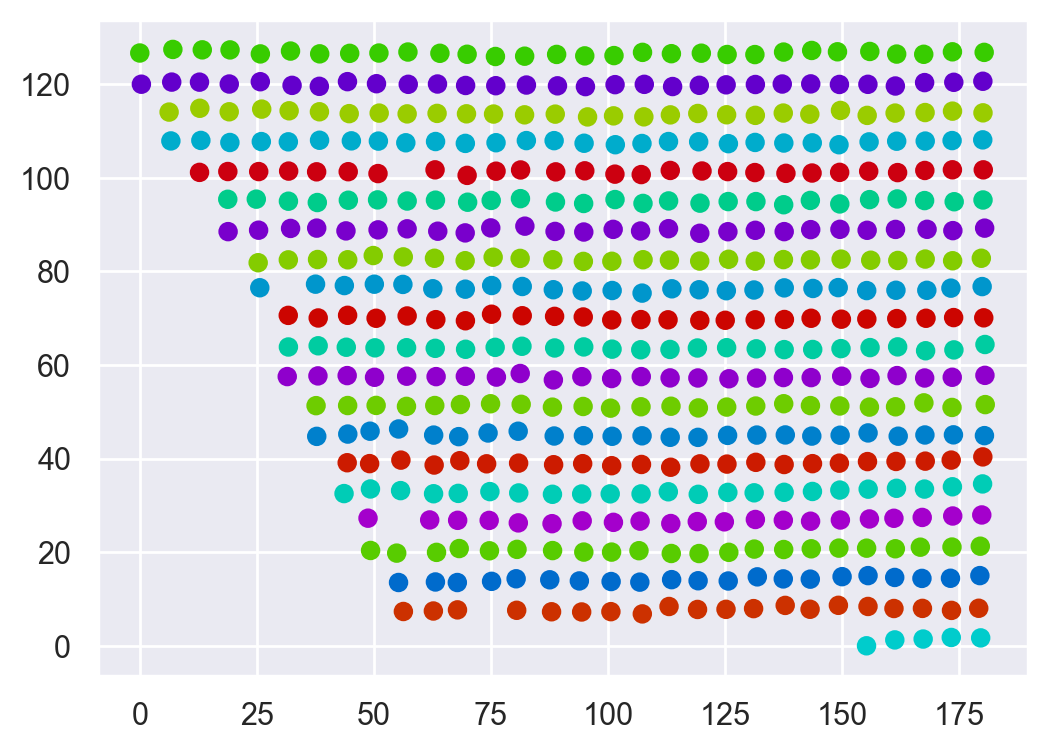

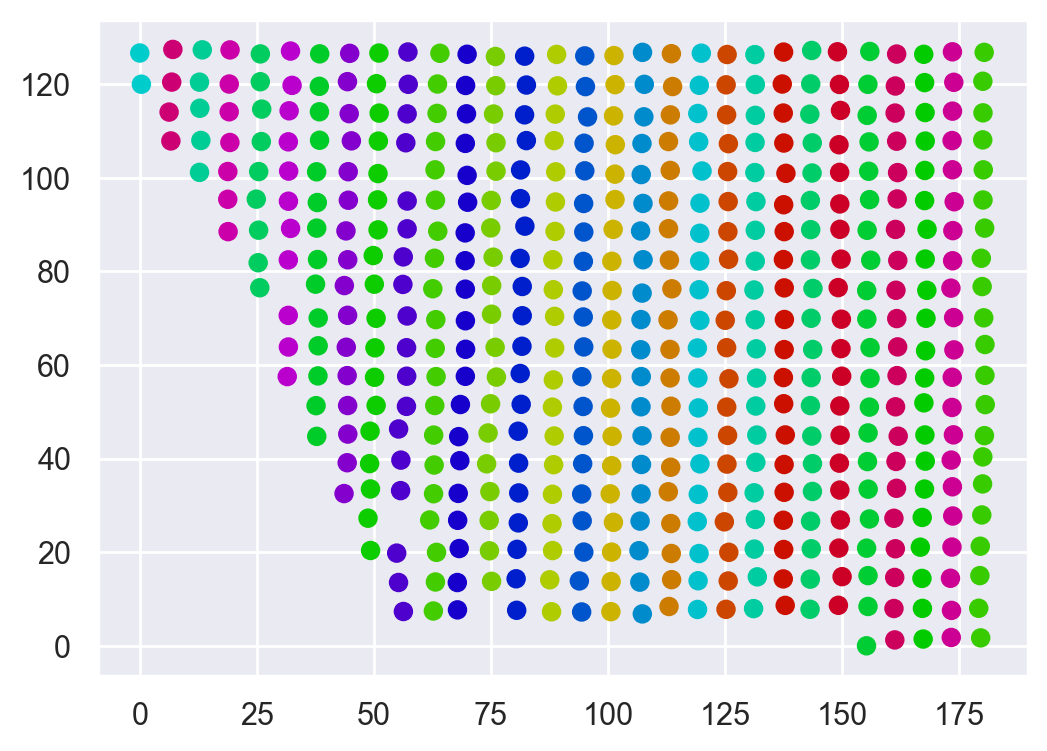

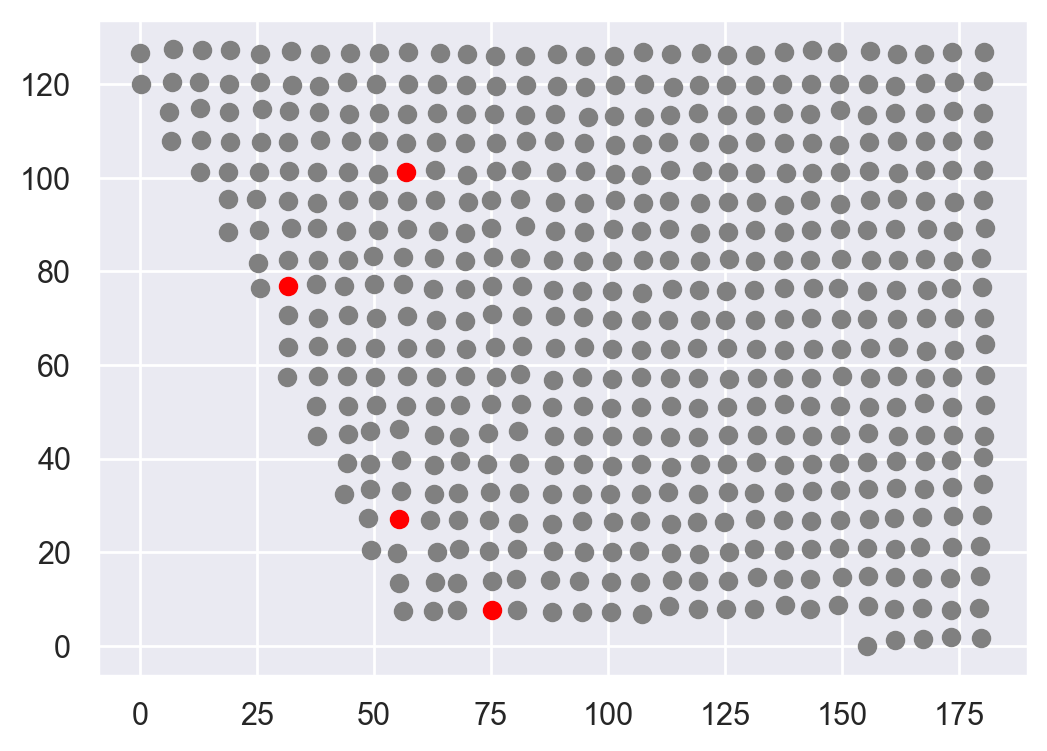

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import colorsys

def create_cmap(N, lightness=0.4, saturation=1.0):
    hues = [(0.5 + i * np.pi) % 1.0 for i in range(N)]
    rgb_colors = [colorsys.hls_to_rgb(h, lightness, saturation) for h in hues]
    return plt.cm.colors.ListedColormap(rgb_colors)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', 'box')
plt.scatter(x=gdf['grid_x'], y=gdf['grid_y'], c=gdf['row'], cmap=create_cmap(len(gdf['row'])))
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', 'box')
plt.scatter(x=gdf['grid_x'], y=gdf['grid_y'], c=gdf['col'], cmap=create_cmap(len(gdf['col'])))
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', 'box')
plt.scatter(x=gdf['grid_x'], y=gdf['grid_y'], c='gray')
plt.scatter(x=missing_points[:,1], y=missing_points[:,0], c='red')
plt.show()

In [ ]:
latitude, longitude = gdf['latitude'].values, gdf['longitude'].values

def compute_grid(latitude, longitude):
    easting, northing, zone_number, zone_letter = utm.from_latlon(latitude, longitude) 
    utm_points = np.column_stack((easting, northing))
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(utm_points)
    nn_dists, nn_indices = nbrs.kneighbors(utm_points)
    delta = np.subtract(utm_points[nn_indices[:,0]], utm_points[nn_indices[:,1]])
    angles = np.arctan2(delta[:,1], delta[:,0])%(np.pi/2)
    grid_angle = -np.median(angles) #subtract first quadrant angle
    R = np.array([[np.cos(grid_angle), -np.sin(grid_angle)], 
                [np.sin(grid_angle),  np.cos(grid_angle)]])
    utm_centre = np.mean(utm_points, axis=0)
    grid_points = (R @ (utm_points - utm_centre).T).T

    def grid_to_latlon(grid_points):
        utm_points = (R.T @ grid_points.T).T + utm_centre
        latitude, longitude = utm.to_latlon(utm_points[:,0], utm_points[:,1], zone_number, zone_letter)
        return latitude, longitude
    
    return grid_points, grid_to_latlon

In [1]:
class Grid:
    def __init__(self, latitude, longitude):
        self.latitude = latitude
        self.longitude = longitude
        easting, northing, self.zone_number, self.zone_letter = utm.from_latlon(self.latitude, self.longitude)
        utm_points = np.column_stack((easting, northing))
        self.utm_centre = np.mean(utm_points, axis=0)
        self.nn_dists, self.nn_indices = self.nearest_neighbour(utm_points)
        self.grid_angle = self.calculate_grid_angle(utm_points) #first quadrant angle
        self.x, self.y = self.utm_to_grid(utm_points)
        self.rows, self.cols = self.label_grid_points(self.x, self.y)

    @staticmethod
    def nearest_neighbour(points):
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(points)
        return nbrs.kneighbors(points)
    
    @staticmethod
    def rot_matrix(angle):
        return np.array([[np.cos(angle), -np.sin(angle)], 
                         [np.sin(angle),  np.cos(angle)]])
    
    def utm_to_grid(self, utm_points):
        x, y = (self.rot_matrix(-self.grid_angle) @ (utm_points - self.utm_centre).T)
        return x, y
    
    def calculate_grid_angle(self, utm_points):
        delta = np.subtract(utm_points[self.nn_indices[:,0]], utm_points[self.nn_indices[:,1]])
        angles = np.arctan2(delta[:,1], delta[:,0]) % (np.pi/2)
        return np.median(angles)

    def grid_to_latlon(self, grid_points):
        utm_points = (self.rot_matrix(self.grid_angle) @ grid_points.T).T + self.utm_centre
        latitude, longitude = utm.to_latlon(utm_points[:,0], utm_points[:,1], self.zone_number, self.zone_letter)
        return latitude, longitude
    
    def label_grid_points(self, x, y):
        def sort_cluster_labels(coords, labels):
            cluster_medians = {c: np.median(coords[labels == c]) for c in np.unique(labels)}
            sorted_clusters = sorted(cluster_medians, key=cluster_medians.get)
            cluster_to_label = {c: i for i, c in enumerate(sorted_clusters)}
            return np.array([cluster_to_label[c] for c in labels])
        # TODO: DETERMINE SWEET SPOT FOR EPS - I THINK THIS IS CLOSE
        eps = np.min(self.nn_dists[:,1])/2
        dbscan = DBSCAN(eps=eps, min_samples=2, metric='manhattan')
        rows = sort_cluster_labels(y, dbscan.fit(y.reshape((-1,1))).labels_)
        cols = sort_cluster_labels(x, dbscan.fit(x.reshape((-1,1))).labels_)
        return rows, cols

    def plot(self, ax=None, c=None):
        if ax is None:
            _, ax = plt.subplots(1,1)
        ax.set_aspect('equal', 'box')
        plt.scatter(x=self.x, y=self.y, c=c, cmap='viridis')
        return ax


    def detect_missing_points(self):
        # TODO: FLOOD FILL
        # TODO: EXCLUDE POINTS BASED ON POLYGON
        grid_table = {(r, c):(x, y) for r, c, x, y in zip(self.rows, self.cols, self.x, self.y)}
        missing = []
        for r in np.unique(self.rows[self.rows!=-1]):
            for c in np.unique(self.cols[self.cols!=-1]):
                if (r,c) not in grid_table:
                    neighbours = [grid_table[pos] for pos in ((r-1,c), (r+1,c), (r,c-1), (r,c+1)) if pos in grid_table]
                    if len(neighbours) > 2 :
                        missing.append(np.median(neighbours, axis=0))
        return np.array(missing)


grid = Grid(gdf['latitude'].values, gdf['longitude'].values)
grid.plot(c=grid.rows)
plt.show()

grid.plot(c=grid.cols)
plt.show()


missing = grid.detect_missing_points()
print(missing)
ax = grid.plot()
ax.scatter(x=missing[:,0], y=missing[:,1])

NameError: name 'gdf' is not defined